### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

### **Below contains all functions used to generate our final results**

In [ ]:

import numpy as np
import imageio
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances
import math
#new class in numpy.random, default_rng
#https://linuxtut.com/en/2a959e5731ef5c9191a6/
rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images
print(mpl.__version__)



3.2.2


In [ ]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax
CLEW_SIZE=100;
MAX_ITER=10;
FIT_GOAL=0;

In [ ]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(imageio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

Image name (shape) (intensity max, min, mean, std)



FileNotFoundError: ignored

In [ ]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))#min 3
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)

    def env_colours(self, image):
        colours=[]
        intermediates = np.int64(np.round(self.intermediate_points()))
        for point in intermediates:
            if 0< point[0]< image.shape[1] and 0< point[1]< image.shape[0]:
                colours.append(image[point[1],point[0]])
        return(np.array(colours)/255)

    def quadratic_bezier_fd(self,t):
        '''
        quadratic bezier first derivative
        '''
        return 2*(1-t)*(self.control_points()[1]-self.control_points()[0])+2*t*(self.control_points()[2]-self.control_points()[1])

    def quadratic_bezier_sd(self):
        '''
        quadratic bezier second derivative
        '''
        return 2*(self.control_points()[2]-2*self.control_points()[1]+self.control_points()[0])

    def curvature_at_t(self,t):
        """
        Compute curvature at one point given first and second derivatives.
        :param dx: (float) First derivative along x axis
        :param dy: (float)
        :param ddx: (float) Second derivative along x axis
        :param ddy: (float)
        :return: (float)
        """
        dx, dy = self.quadratic_bezier_fd(t)
        ddx, ddy = self.quadratic_bezier_sd()
        return abs((dx * ddy - dy * ddx))/ (dx ** 2 + dy ** 2) ** (3 / 2)

    def max_curvature(self):
        curvature_list=[]
        for t in np.linspace (0,1,100):
            curvature_list.append(self.curvature_at_t(t))
        return min(max(curvature_list),100)
        

In [ ]:
def mutation(imshape,worm):
    #3. Mutation function: randomly and slightly increase or decrease some worm 
    # parameters in part of the clew
    #m=np.random.rand();
    m=0.5;
    min_colour=0.0
    max_colour=1.0
    (ylim, xlim) = imshape
    min_x = 0
    max_x = xlim
    min_y = 0
    max_y = ylim
    min_r = 0
    min_dr = 0
    min_width = 0
    max_width =50
    uf_range =[0.8,1.2]
    uf_range2 = [0.9,1.1]
    if(np.random.rand()<m):
        #worm.x=np.random.normal(np.mean([worm.x for worm in clew]),np.std([worm.x for worm in clew]));
        worm.x=np.random.uniform(uf_range[0],uf_range[1])*worm.x
        worm.x = max(min(worm.x,max_x),min_x)
    if(np.random.rand()<m):
        #worm.y=np.random.normal(np.mean([worm.y for worm in clew]),np.std([worm.y for worm in clew]));
        worm.y=np.random.uniform(uf_range[0],uf_range[1])*worm.y
        worm.y = max(min(worm.y,max_y),min_y)
    if(np.random.rand()<m):
        #worm.r=np.random.normal(np.mean([worm.r for worm in clew]),np.std([worm.r for worm in clew]));
        worm.r=np.random.uniform(uf_range[0],uf_range[1])*worm.r
        worm.r = max(worm.r,min_r)
    if(np.random.rand()<m):
        #worm.theta=np.random.normal(np.mean([worm.theta for worm in clew]),np.std([worm.theta for worm in clew]));
        worm.theta=np.random.uniform(uf_range[0],uf_range[1])*worm.theta
    if(np.random.rand()<m):
        #worm.dr=np.random.normal(np.mean([worm.dr for worm in clew]),np.std([worm.dr for worm in clew]));
        worm.dr=np.random.uniform(uf_range[0],uf_range[1])*worm.dr
        worm.dr = max(worm.dr,min_dr)
    if(np.random.rand()<m):
        #worm.dgamma=np.random.normal(np.mean([worm.dgamma for worm in clew]),np.std([worm.dgamma for worm in clew]));
        worm.dgamma=np.random.uniform(uf_range[0],uf_range[1])*worm.dgamma
    if(np.random.rand()<m):
        #worm.width=np.random.normal(np.mean([worm.width for worm in clew]),np.std([worm.width for worm in clew]));
        worm.width=np.random.uniform(uf_range2[0],uf_range2[1])*worm.width
        worm.width = max(min(worm.width,max_width),min_width)
    if(np.random.rand()<m):
        #worm.colour=np.random.normal(np.mean([worm.colour for worm in clew]),np.std([worm.colour for worm in clew]));
        worm.colour=np.random.uniform(uf_range2[0],uf_range2[1])*worm.colour
        worm.colour = max(min(worm.colour,max_colour),min_colour)
    return Camo_Worm(worm.x, worm.y, worm.r, worm.theta, worm.dr,  worm.dgamma, worm.width, worm.colour)

In [ ]:
def crossover(s1,s2,pos):
    #Crossover function used in final crossover

    #from worm 1 (s1) and worm 2 (s2) we save all worm parameter values into these np arrays for np array manipulation 
    s1_array=np.array([s1.x, s1.y, s1.r, s1.theta, s1.dr, s1.dgamma, s1.width, s1.colour]);
    s2_array=np.array([s2.x, s2.y, s2.r, s2.theta, s2.dr, s2.dgamma, s2.width, s2.colour]);
    
    #generate slice defined by poistion for each worm
    s1_slice=s1_array[pos::];
    s2_slice=s2_array[pos::];

    #crossover worms so that s1 has s2's slice after position and vice versa 
    s1_cross_array=np.concatenate((s1_array[0:pos],s2_slice),dtype='float');
    s2_cross_array=np.concatenate((s2_array[0:pos],s1_slice),dtype='float');
    
    #return camo worms with worm parmeters of s1 and s2 cross arrays
    return Camo_Worm(s1_cross_array[0], s1_cross_array[1], s1_cross_array[2], s1_cross_array[3], s1_cross_array[4],  s1_cross_array[5], s1_cross_array[6], s1_cross_array[7]),Camo_Worm(s2_cross_array[0], s2_cross_array[1], s2_cross_array[2], s2_cross_array[3], s2_cross_array[4],  s2_cross_array[5], s2_cross_array[6], s2_cross_array[7])

In [ ]:
CLEW_SIZE=1000;
CLEW_GEN=1;
def optimization_1_clew_no_cross_function():
    'minimize energy function'
    #1. Generation function 
    # 1.1 initial generation: generate initial clew of size CLEW_SIZE (containing CLEW_SIZE worms)
    clew_array_init=[];
    best_clew_array_init=[];
    clew_energy_array=[];
    clew_array_init=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
    iterator=0;
    MAX_ITER=200;
    average_energy=[];
    grow_energy_array=[];
    curv_energy_array=[];
    distance_energy_array=[];
    too_close_energy_array=[];
    total_diff_energy_array=[];
    colour_std_energy_array=[];

    #optimize in a loop until stopping criteria is met for iterator 
    while iterator<MAX_ITER:
        iterator+=1;

        # 1.2 new generation: Select the best of clews, mid 80%
        # for mutation via sorting clew via single worm energy 
        clew_energy_array=[];
        for worm in clew_array_init:
          energy=single_worm_energy(image, worm, clew_array_init);
          clew_energy_array.append(energy[0]);
          grow_energy_array.append(energy[1]);
          curv_energy_array.append(energy[2]);
          distance_energy_array.append(energy[3]);
          too_close_energy_array.append(energy[4]);
          total_diff_energy_array.append(energy[5]);
          colour_std_energy_array.append(energy[6]);
        sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
        clew_sorted=[clew_array_init[i] for i in sorted_array_index];
        energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
        mid_80_clew=clew_sorted[int(len(clew_sorted)*0.1):int(len(clew_sorted)*0.9)];
        bot_10_clew=clew_sorted[0:int(len(clew_sorted)*0.1)];
        average_energy.append(np.mean(energy_sorted[0:int(len(energy_sorted)*0.2)]));
      

        #mutate new generation being the mid_80_clew
        new_generation=mid_80_clew;
        mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(CLEW_SIZE/5)];
        for i in mutation_index:
            temp_mut=copy.deepcopy(new_generation[i]);
            temp_mut=mutation(image.shape,temp_mut);
            new_generation[i]=copy.deepcopy(temp_mut);

        #assign next generation from elite 10%, mutated mid 80% and random 10%
        clew_array_init=bot_10_clew+new_generation+initialise_clew(int(CLEW_SIZE/10), image.shape, (40, 30, 1));
        if iterator%10==0 or iterator==1:
          print("iterator: ",iterator)
          drawing = Drawing(image)
          drawing.add_worms(bot_10_clew)
          drawing.show()
    print(average_energy)
    mpl.pyplot.figure();
    mpl.pyplot.plot(average_energy);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('GA Optimization')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(grow_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('grow energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(curv_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('curvature energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(distance_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('distance energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(too_close_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('too close energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(total_diff_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('total difference energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(colour_std_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('colour_stdr energy')
    mpl.pyplot.figure();
    return bot_80_clew, clew_array_init
#bot_80_clew, clew_array_init =optimization_1_clew_no_cross_function()

In [ ]:
#Final crossover function used in project for worm by worm crossover and energy evalution 
def optimization_1_clew_final_function():
    'minimize energy function'
    #1. Generation function 
    # 1.1 initial generation: single random clew containing CLEW_SIZE worms is generated
    
    clew_array_init=[];
    best_clew_array_init=[];
    clew_energy_array=[];
    clew_array_init=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
    iterator=0;
    average_energy=[];
    total_best_50=[];
    grow_energy_array=[];
    curv_energy_array=[];
    distance_energy_array=[];
    too_close_energy_array=[];
    total_diff_energy_array=[];
    colour_std_energy_array=[];

    #set termination criteria for optimization function, function will stop once iteration reaches MAX_ITER
    while iterator<MAX_ITER:
        iterator+=1;
        clew_energy_array=[];

        # 1.2 new generation: We sort our clew via individual worm energies 
        # and then select the best 50% as elites to save for new generation
        # then apply crossover and mutation for new generation
        # all energy arrays are used to track how optimization function minimizes all aspects
        # of the cost function
        for worm in clew_array_init:
          energy=single_worm_energy(image, worm, clew_array_init);
          clew_energy_array.append(energy[0]);
          grow_energy_array.append(energy[1]);
          curv_energy_array.append(energy[2]);
          distance_energy_array.append(energy[3]);
          too_close_energy_array.append(energy[4]);
          total_diff_energy_array.append(energy[5]);
          colour_std_energy_array.append(energy[6]);
        
        #sort the clew via the worm energies in increasing order
        sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
        clew_sorted=[clew_array_init[i] for i in sorted_array_index];
        energy_sorted=[clew_energy_array[i] for i in sorted_array_index];

        #select best 50%
        bot_50_clew=clew_sorted[0:int(len(clew_sorted)*0.5)];
        rejected_50=clew_sorted[int(len(clew_sorted)*0.5)::];
        total_best_50.append(bot_50_clew)
        average_energy.append(np.mean(energy_sorted[0:int(len(energy_sorted)*0.2)]));

        #define position for crossover 
        pos=np.random.randint(1,6);
        clew_size_pos_div=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
        clew_array_rand=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
        bot_50_copy=copy.deepcopy(bot_50_clew);

        #define number of worms to crossover to form portion of new generation 
        for crossover_iterator in range(0,int(CLEW_SIZE*0.5)):

          #generate random selection indexes 
          worm_select_index_s1=np.random.randint(0,len(bot_50_clew));
          worm_select_index_s2=np.random.randint(0,len(bot_50_clew));

          s1=copy.deepcopy(bot_50_clew[worm_select_index_s1]);
          s2=copy.deepcopy(bot_50_clew[worm_select_index_s2]);

          #crossover s1 for first worm and s2 for second worm
          cross_arrays=crossover(s1,s2,pos);
          s1=copy.deepcopy(cross_arrays[0]);
          s2=copy.deepcopy(cross_arrays[1]);
    
          #save crossover worms into bot_50_copy for new generation
          bot_50_copy[worm_select_index_s1]=Camo_Worm(s1.x, s1.y, s1.r, s1.theta, s1.dr,  s1.dgamma, s1.width, s1.colour)
          bot_50_copy[worm_select_index_s2]=Camo_Worm(s2.x, s2.y, s2.r, s2.theta, s2.dr,  s2.dgamma, s2.width, s2.colour)
       
        cross_clew_energy_array=[];
        
        #define new generation
        new_generation=bot_50_copy+bot_50_clew;

        #generate mutation index to select worms to mutate in new generation
        mutation_index=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/5)];
        for i in mutation_index:
            #mutate worm at mutation index and save into temp_mut
            temp_mut=copy.deepcopy(new_generation[i]);
            temp_mut=mutation(image.shape,temp_mut);
            #save temp_mut into new_generation
            new_generation[i]=copy.deepcopy(temp_mut);
        #new generation is now assigned to clew_array
        #for evaluation and looping
        clew_array_init=new_generation;
        if iterator%100==0 or iterator==1:
          print("iterator: ",iterator)
          drawing = Drawing(image)
          drawing.add_worms(clew_array_init)
          drawing.show()
    print(average_energy)
    mpl.pyplot.figure();
    mpl.pyplot.plot(average_energy);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('GA Optimization')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(grow_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('grow energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(curv_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('curvature energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(distance_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('distance energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(too_close_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('too close energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(total_diff_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('total difference energy')
    mpl.pyplot.show()
    mpl.pyplot.figure();
    mpl.pyplot.plot(colour_std_energy_array);
    mpl.pyplot.xlabel('Number of iterations')
    mpl.pyplot.ylabel('Cost')
    mpl.pyplot.title('colour_stdr energy')
    mpl.pyplot.figure();
    return clew_array_init
#clew_array_init =optimization_1_clew_final_function()

In [ ]:

def findsmallestdistance(worm1points,worm2points):
    
    smallestdistance = None
    
    #for each point in worm 1
    for i in range(len(worm1points)):
        worm1point = worm1points[i]
        worm1x = worm1point[0]
        worm1y = worm1point[1]

        #for each point in worm 2
        for j in range(len(worm2points)):
            worm2point = worm2points[j]
            
            #Get distance between the point
            distance = math.dist(worm1point,worm2point)
            
            if(not smallestdistance):
                smallestdistance = distance
            # replace current mallest distance with new
            elif(distance <= smallestdistance):
                smallestdistance = distance
    
    return smallestdistance



# return minimum of closest distance of each worm to all other worms
def returnSetOfClosestDistances(intermediatepointset):
    setofclosestdistances = []
    #for each worm
    for i in range(len(intermediatepointset)):
        currentwormpoints = intermediatepointset[i]  
        smallestdistances = []

        #for each other worm
        for j in range(len(intermediatepointset)):
            if(i != j): #make sure its not the same worm
                otherwormpoints = intermediatepointset[j]
                #find smallest distance between these 2 worms
                smallestdistance = findsmallestdistance(currentwormpoints,otherwormpoints)
                #add current smallest distance into list of distances
                smallestdistances.append(smallestdistance)

        # worm i compared to all others - average all the closest distances-- 
        #averageofsmallestdistances = sum(smallestdistances)/len(smallestdistances)
        #(or maybe just get the min?)
        averageofsmallestdistances = min(smallestdistances)
        # add smallest distance to set
        setofclosestdistances.append(averageofsmallestdistances)

    return(setofclosestdistances)



def getBoundingRectangleForWorm(worm,mapx,mapy):
    IP = worm.intermediate_points(5)    
    #set minimum to the top to be dragged down
    minx=mapx+1
    #set maximum to the top to be dragged down
    maxx=-1

    miny=mapy+1
    maxy=-1

    for point in IP:
        pointx = point[0]
        pointy = point[1]

        if pointx < minx:
            minx = pointx
        
        if pointx > maxx:
            maxx = pointx
        
        if pointy < miny:
            miny = pointy
        
        if pointy > maxy:
            maxy = pointy

    # ADD 1% error to all sides
    errorx = mapx*0.01
    errory = mapy*0.01

    minx = minx-errorx
    maxx = maxx+errorx

    miny = miny-errory
    maxy = maxy+errory


    # check bounds
    if minx < 0:
        minx = 0
    if maxx > mapx:
        maxx = mapx

    if miny < 0:
        miny = 0
    if maxy > mapy:
        maxy = mapy

    finalset = (minx,maxx),(miny,maxy)
    return(finalset)

def returnTotalOverlays(clew,stepsizex = 1,stepsizey=1):
    mapx = image.shape[1] # -- X is the second value somehow
    mapy = image.shape[0]
    
    mapxcoord = int(mapx/stepsizex)
    mapycoord = int(mapy/stepsizey)
    #Create coordinate mapping
    map = [[0 for i in range(mapycoord)] for j in range(mapxcoord)]
    
    totalOverlaysWithRepeats = 0
    totalPointsCovered = 0


    #Handle Colours
    allcolours = []

    # for each worm
    for worm in clew:
    #for wormnumber in range(len(intermediatepointset)):
        #currentwormpoints = intermediatepointset[wormnumber]
        bound = getBoundingRectangleForWorm(worm,mapx,mapy)
        #bound = getBoundingRectangleForWorm(worm,mapx,mapy)
        minx = int(bound[0][0]/stepsizex)
        maxx = int(bound[0][1]/stepsizex)
        
        miny = int(bound[1][0]/stepsizey)
        maxy = int(bound[1][1]/stepsizey)
        

        #Handle Colours
        wormcolours = []

        ## only look through points within it's bounding rectangle -- saves a LOT of processing
        for i in range(minx,maxx):
            for j in range(miny,maxy): 
                # For each point
                point = i,j 
                # check if worm is on the point - need to scale back the points i and j to map coordinates
                checkpoint = i*stepsizex,j*stepsizey
                check = worm.patch().contains_point(checkpoint)
                # if worm IS on the point
                if(check):
                    # immediately add it to the point
                    map[i][j] += 1
                    
                    # check if it is the only worm there. IF not, add to total overlays
                    if(map[i][j] > 1):
                        totalOverlaysWithRepeats += 1
                    
                    # If it is the First on this point, add to total points covered
                    if(map[i][j] == 1):
                        totalPointsCovered += 1

                    #Add image colour to this worm
                    pointcolour = image[j*stepsizey, i*stepsizex]/255
                    wormcolours.append(pointcolour)
        allcolours.append(wormcolours)

    # Return both values
    return(totalOverlaysWithRepeats,totalPointsCovered,allcolours)


    
def returnNumberOfWormsTooClose(penaliseddistance,closestdistances):
    numberofpenaliseddistances = 0
    for distance in closestdistances:
        if distance <= penaliseddistance:
            numberofpenaliseddistances+=1
    return(numberofpenaliseddistances)

# return minimum of closest distance of a worm to all other worms
def returnClosestDistance(mainworm,clew):
    finalsmallestdistance = None
    # get main worm points 
    currentwormpoints = mainworm.intermediate_points()
    #for each worm
    for worm in clew:
        # If its not itself
        if worm != mainworm:
            #get other worms points
            otherwormpoints = worm.intermediate_points()
            # get smallest distance between the worms
            smallestdistance = findsmallestdistance(currentwormpoints,otherwormpoints)
            
            # final smallest not initialised
            if not finalsmallestdistance:
                finalsmallestdistance=smallestdistance
            # final smallest initialised and newsmallest is better
            elif smallestdistance < finalsmallestdistance:
                finalsmallestdistance=smallestdistance

    return finalsmallestdistance


def getEdgeDistanceAndOverlay(worm1,worm2):
    
    totalpointschecked = 0
    numberofoverlaypoints = 0

    closestedgedistance = None
    # For each point in worm 1
    for worm1point in worm1.intermediate_points():
        #Increment total points checked only for worm1 points
        totalpointschecked+=1

        for worm2point in worm2.intermediate_points():


            #get distance between both points
            seperatingdistance = math.dist(worm1point,worm2point)

            # get width of both worms added together
            addedwidths = worm1.width + worm2.width
            
            # If seperating distance is closer than the width of both worms
            if (addedwidths > seperatingdistance):
                numberofoverlaypoints += 1
                # worm 1 point considered "overlayed"
                # 0 seperating distance
                closestedgedistance = 0
                # Dont bother checking other points in worm 2
                # start checking next point for worm 1
                break
    
            # There is space between edge of worms
            else:
                edgedistance = seperatingdistance-addedwidths
                
                #closest not initialised yet
                if not closestedgedistance:
                    closestedgedistance = edgedistance

                elif edgedistance < closestedgedistance:
                    closestedgedistance = edgedistance
    
    return (closestedgedistance,numberofoverlaypoints,totalpointschecked)

In [ ]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [ ]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [ ]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

AttributeError: ignored

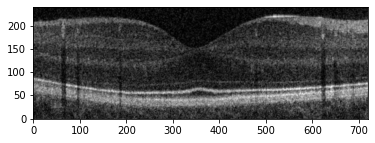

In [ ]:
# Draw a single worm along with control points and some sample points
#      Camo_Worm(  x,   y,  r,   theta, deviation_r, deviation_gamma, width, colour)
worm = Camo_Worm(200, 100, 50, np.pi/6,          70,         np.pi/3,    10,    0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

AttributeError: ignored

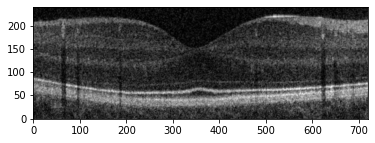

In [ ]:
# Initialise clew of 100 and draw

clew = initialise_clew(100, image.shape, (40, 30, 1))
drawing = Drawing(image)
#print(len(clew))
drawing.add_worms(clew)
drawing.show()

In [ ]:
def single_worm_energy(image, worm,clew, w_i=1, w_g=1, w_e=10):
    w_grow =2000
    w_curvature = 100
    w_distance = 1
    w_close = 1
    w_overlay = 1
    w_diff = 15
    w_std = 100
    #cost function

    worm_size = worm.approx_length() * worm.width
    # 1. internal energy
    #   1.1 grow energy (favors big size - long and wide)
    #   1.2 curvature energy (favors smooth curves)
    grow_energy = w_grow/worm_size
    curvature_energy = w_curvature*worm.max_curvature()
    internal_energy = grow_energy + curvature_energy
       
# 2. group energy (favors own space, be distant from other worms)
    totalpoointschecked = 0
    totaloverlayedpoints = 0
    
    mainclosestdistance = None
    #for each worm
    for otherworm in clew:
        # dont compare with itself
        if worm != otherworm:
            closestdistance , worm1overlayedpoints , worm1pointschecked  = getEdgeDistanceAndOverlay(worm,otherworm)
            #current closest not initialised
            if not mainclosestdistance:
                mainclosestdistance=closestdistance
            # Update closest distance for mainworm
            elif closestdistance< mainclosestdistance:
                mainclosestdistance=closestdistance

            totalpoointschecked += worm1pointschecked
            totaloverlayedpoints += worm1overlayedpoints
    
    ## set threshold distance for too close worms
    penaliseddistance = 10
    tooclose = 0

    if mainclosestdistance <= penaliseddistance:
        tooclose = 1
    
    
    worm_num = len(clew)
    too_close_energy = w_close*tooclose
    
    maxdistance = math.sqrt(image.shape[0] *image.shape[0] + image.shape[1]*image.shape[1])

    distance_energy = None
    if(mainclosestdistance == 0):
        distance_energy = 1*w_distance
    else:                              
        distance_energy =w_distance * ((maxdistance-mainclosestdistance)/maxdistance)
    
    # Percentage of points on each worm which has been overlayed
    overlay_energy = w_overlay*totaloverlayedpoints/totalpoointschecked

    group_energy = distance_energy+too_close_energy+overlay_energy

    #3. environment energy (favors same colour to the covered area)
    total_diff = 0
    num_points = 0
    colour_array = worm.env_colours(image)
    for i in range(0, len(worm.env_colours(image))): #check colour of worm at 10 different points
        total_diff += abs(worm.colour - worm.env_colours(image)[i]) # compare colour of worm to image colour at each point, and add a value between 0 and 1 to total diff based on how close the colours are
        num_points += 1
    if len(colour_array)>0:
        colour_std = w_std*np.std(colour_array)
    else:
        colour_std = w_std
    if num_points == 0: # avoid division by 0
        total_diff = w_diff
    else:
        total_diff = w_diff*total_diff / num_points # find average diff per point - value will be between 0 and 1, 0 being perfect match of colour, 1 being complete mismatch

    #environment_energy = 1.2 ** (10 - total_diff * 10) - 1 # lower diff gives higher environment energy. The current equation gives a range of 0-5.2 for environment energy and can (should) be adjusted as required.
    
    environment_energy= total_diff+colour_std
    #environment_energy=0
    total_energy = w_i*internal_energy + w_g*group_energy + w_e*environment_energy
    # print("distance_energy: ", distance_energy)
    # print("too_close_energy: ", too_close_energy)
    # print("overlay_energy: ", overlay_energy)
    # print("grow_energy: ", grow_energy)
    # print("curvature_energy: ", curvature_energy)
    # print("total_diff: ", total_diff)
    # print("mean_colour_std: ", mean_colour_std)
    return total_energy, grow_energy, curvature_energy, distance_energy,too_close_energy, total_diff, colour_std
# for i in range(0, 1000):
#     clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
#     worm= clew[np.random.randint(0,CLEW_SIZE)]
#     print(single_worm_energy(image, worm, clew))

In [ ]:
blank_img = np.zeros([image.shape[0],image.shape[1],1],dtype=np.uint8)
blank_img = np.zeros(image.shape)
blank_img[:]=255 # or img[:] = 255
best_clew=total_best_20[-1][0]
print("best clew energy: ", worm_energy(image, best_clew))
drawing = Drawing(image)
drawing.add_worms(best_clew)
drawing.show()
drawing = Drawing(blank_img)
drawing.add_worms(best_clew)
drawing.show()

### Below are all previous implementations and prototypes now unused

In [ ]:
# def clew_crossover(clew1,clew2,pos):
#     temp_clew_1=copy.deepcopy(clew1);
#     temp_clew_2=copy.deepcopy(clew2);
#     temp_clew_1_slice=temp_clew_1[pos::];
#     temp_clew_2_slice=temp_clew_2[pos::];
#     temp_clew_1[pos::]=temp_clew_2_slice;
#     temp_clew_2[pos::]=temp_clew_1_slice;
#     print(worm_energy(image,temp_clew_1),worm_energy(image,temp_clew_2))
#     return [temp_clew_1,temp_clew_2]

In [ ]:
# def crossover(s1,s2,pos):
#     #3. Mutation function: randomly and slightly increase or decrease some worm 
#     # parameters in part of the clew
#     s1_array=np.array([s1.x, s1.y, s1.r, s1.theta, s1.dr, s1.dgamma, s1.width, s1.colour]);
#     s2_array=np.array([s2.x, s2.y, s2.r, s2.theta, s2.dr, s2.dgamma, s2.width, s2.colour]);
#     #print(s1_array)
#     #print(s2_array)
#     s1_slice=s1_array[pos::];
#     s2_slice=s2_array[pos::];
#     s1_cross_array=np.concatenate((s1_array[0:pos],s2_slice),dtype='float');
#     s2_cross_array=np.concatenate((s2_array[0:pos],s1_slice),dtype='float');
#     #print(s1_cross_array)
#     #print(s2_cross_array)
#     return s1_cross_array,s2_cross_array

In [ ]:
# def clew_crossover_3(clew1,clew2,clew3,pos1,pos2):
#     temp_clew_1=copy.deepcopy(clew1);
#     temp_clew_2=copy.deepcopy(clew2);
#     temp_clew_3=copy.deepcopy(clew3);
#     temp_clew_1_slice_1=temp_clew_1[pos1::];
#     temp_clew_2_slice_1=temp_clew_2[pos1::];
#     temp_clew_3_slice_1=temp_clew_3[pos1::];
#     temp_clew_1_slice_2=temp_clew_1[pos2::];
#     temp_clew_2_slice_2=temp_clew_2[pos2::];
#     temp_clew_3_slice_2=temp_clew_3[pos2::];
#     temp_clew_1[pos1::]=temp_clew_3_slice_1;
#     temp_clew_2[pos1::]=temp_clew_1_slice_1;
#     temp_clew_3[pos1::]=temp_clew_2_slice_1;
#     temp_clew_1[pos2::]=temp_clew_2_slice_2;
#     temp_clew_2[pos2::]=temp_clew_3_slice_2;
#     temp_clew_3[pos2::]=temp_clew_1_slice_2;
#     #print(worm_energy(image,temp_clew_1),worm_energy(image,temp_clew_2))
#     return [temp_clew_1,temp_clew_2,temp_clew_3]

In [ ]:
# def evaluation(best_clew,clew):
#     #4. Evaluation function: for example, evaluate the energy function 
#     # for a generation (1000 clew) and save the best 10% clew in list
#     best_clew_energy=single_worm_energy(image, best_clew, w_i=1, w_g=1, w_e=2);
#     clew_energy=single_worm_energy(image, clew, w_i=1, w_g=1, w_e=2); 
#     if clew_energy<best_clew_energy:
#         temp_1=copy.deepcopy(best_clew);
#         temp_2=best_clew_energy;
#         best_clew=copy.deepcopy(clew);
#         best_clew_energy=clew_energy;
#         clew=copy.deepcopy(temp_1);
#         clew_energy=temp_2;
#     return best_clew, best_clew_energy, clew_energy, clew

In [ ]:
# CLEW_SIZE=100;
# CLEW_GEN=100;
# def optimization_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     for jj in range(0,CLEW_GEN):
#         clew_array_init.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=10;
#     average_20_energy=[];
#     total_best_20=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         clew_energy_array=[];
#         for jj in range(0,CLEW_GEN):
#             clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_20_clew=clew_sorted[0:int(len(clew_sorted)/5)];
#         total_best_20.append(bot_20_clew);
#         top_20_energy=[];
#         for i in range(0,len(bot_20_clew)):
#             top_20_energy.append(worm_energy(image,bot_20_clew[i]));
#         average_20_energy.append(np.mean(top_20_energy));
#         rejected_80=clew_sorted[int(len(clew_sorted)/5)::];
#         clew_select_index=np.random.permutation(range(0,len(rejected_80)))[0:int(len(rejected_80)/4)];
#         rand_20_clew=[rejected_80[i] for i in clew_select_index];
#         select_40_for_cross_clew=rand_20_clew+bot_20_clew;
#         crossover_pairs_600=np.random.randint(0,len(select_40_for_cross_clew),size=[int((CLEW_GEN)*0.6),2]);
#         crossover_600=[];
#         pos_div=np.random.ranint(10,90);
#         pos=int(CLEW_SIZE/pos_div);
#         for pairs in crossover_pairs_600[0:int(len(crossover_pairs_600)/2)]:
#             cross_array=[];
#             cross_array=clew_crossover(select_40_for_cross_clew[pairs[0]],select_40_for_cross_clew[pairs[1]],pos);
#             crossover_600.append(cross_array[0]);
#             crossover_600.append(cross_array[1]);
#         #print(len(bot_20_clew),len(rand_40_clew),len(crossover_400))
#         new_generation=bot_20_clew+rand_20_clew+crossover_600;
#         mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(len(new_generation)/10)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             for worm_index in worm_indices:
#                 temp_mut[worm_index]=mutation(temp_mut[worm_index],temp_mut);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#     best_clew=total_best_20[0][0]
#     drawing = Drawing(image)
#     drawing.add_worms(best_clew)
#     drawing.show()
#     return average_20_energy,total_best_20

In [ ]:
# CLEW_SIZE=50;
# CLEW_GEN=100;
# def optimization_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     for jj in range(0,CLEW_GEN):
#         clew_array_init.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=5;
#     average_20_energy=[];
#     total_best_20=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         clew_energy_array=[];
#         for jj in range(0,CLEW_GEN):
#             clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_20_clew=clew_sorted[0:int(len(clew_sorted)*0.2)];
#         total_best_20.append(bot_20_clew)
#         top_20_energy=[];
#         for i in range(0,len(bot_20_clew)):
#             top_20_energy.append(worm_energy(image,bot_20_clew[i]));
#         average_20_energy.append(np.mean(top_20_energy));
#         #rejected_80=clew_sorted[int(len(clew_sorted)/5)::];
#         #clew_select_index=np.random.permutation(range(0,len(rejected_80)))[0:int(len(rejected_80)/2)];
#         rand_10_clew=[];
#         for jj in range(0,int(CLEW_GEN/10)):
#             rand_10_clew.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         #select_40_for_cross_clew=rand_20_clew+bot_20_clew;
#         crossover_pairs_20=np.random.randint(0,len(bot_20_clew),size=[int((CLEW_GEN)*0.7),1]);
#         crossover_pairs_10=np.random.randint(0,len(rand_10_clew),size=[int((CLEW_GEN)*0.7),1]);
#         total_crossover_pairs=np.concatenate((crossover_pairs_20, crossover_pairs_10), axis=1);
#         crossover_70=[];
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#             cross_array=[];
#             cross_array=clew_crossover(bot_20_clew[pairs[0]],rand_10_clew[pairs[1]],pos);
#             crossover_70.append(cross_array[0]);
#             crossover_70.append(cross_array[1]);
#         #print(len(bot_20_clew),len(rand_40_clew),len(crossover_400))
#         new_generation=bot_20_clew+rand_10_clew+crossover_70;
#         mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(len(new_generation)/10)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             for worm_index in worm_indices:
#                 temp_mut[worm_index]=mutation(image.shape,temp_mut[worm_index]);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         print("top 20 clew energy: ", top_20_energy)
#         best_clew=total_best_20[-1][0];
#         print("best clew energy: ", worm_energy(image, best_clew))
#         drawing = Drawing(image)
#         drawing.add_worms(best_clew)
#         drawing.show()
#     return average_20_energy,total_best_20,best_clew
# average_20_energy,total_best_20 = optimization_function()

In [ ]:
# To print out min, max, mean for worm attributes, put this in main loop of optimization_function - Lachlan
#        if iterator == MAX_ITER
#            paramlist = []
#            for jj in range(0, CLEW_GEN):
#                paramlist.append(worm_params(image, clew_array_init[jj]))
#            paramlist = np.asarray(paramlist)
#            print(f"min energy: {np.min(paramlist[:, 0])}, mean energy: {np.mean(paramlist[:, 0])}, max energy: {np.max(paramlist[:, 0])}")
#            print(f"min x: {np.min(paramlist[:, 1])}, mean x: {np.mean(paramlist[:, 2])}, max x: {np.max(paramlist[:, 3])}")
#            print(f"min y: {np.min(paramlist[:, 4])}, mean y: {np.mean(paramlist[:, 5])}, max y: {np.max(paramlist[:, 6])}")
#            print(f"min r: {np.min(paramlist[:, 7])}, mean r: {np.mean(paramlist[:, 8])}, max r: {np.max(paramlist[:, 9])}")
#            print(f"min theta: {np.min(paramlist[:, 10])}, mean theta: {np.mean(paramlist[:, 11])}, max theta: {np.max(paramlist[:, 12])}")
#            print(f"min dr: {np.min(paramlist[:, 13])}, mean dr: {np.mean(paramlist[:, 14])}, max dr: {np.max(paramlist[:, 15])}")
#            print(f"min dgamma: {np.min(paramlist[:, 16])}, mean dgamma: {np.mean(paramlist[:, 17])}, max dgamma: {np.max(paramlist[:, 18])}")
#            print(f"min width: {np.min(paramlist[:, 19])}, mean width: {np.mean(paramlist[:, 20])}, max width: {np.max(paramlist[:, 21])}")
#            print(f"min colour: {np.min(paramlist[:, 22])}, mean colour: {np.mean(paramlist[:, 23])}, max colour: {np.max(paramlist[:, 24])}")

In [ ]:
# #Zhihui version
# CLEW_SIZE=50;
# CLEW_GEN=200;
# def optimization_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     clew_array_init=[];
#     clew_energy_array=[];
#     for jj in range(0,CLEW_GEN):
#         clew_array_init.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         clew_energy_array.append(worm_energy(image, clew_array_init[jj]));
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=400;

#     while iterator<MAX_ITER:
#         iterator+=1;
#         print("iterator: ",iterator)
#         clew_energy_array=[];
#         for jj in range(0,CLEW_GEN):
#             clew_energy_array.append(worm_energy(image, clew_array_init[jj]));
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         bot_20_clew=clew_sorted[0:int(len(clew_sorted)*0.2)];
#         top_20_energy=[];
#         for i in range(0,len(bot_20_clew)):
#             top_20_energy.append(worm_energy(image,bot_20_clew[i]));
#         #rand_10_clew=[];
#         #for jj in range(0,int(CLEW_GEN/10)):
#         #    rand_10_clew.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         crossover_pairs_20=np.random.randint(0,len(bot_20_clew),size=[int((CLEW_GEN)*0.8),2]);
#         #crossover_pairs_10=np.random.randint(0,len(rand_10_clew),size=[int((CLEW_GEN)*0.8),1]);
#         total_crossover_pairs=crossover_pairs_20;
#         crossover_80=[];
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#             cross_array=[];
#             cross_array=clew_crossover(bot_20_clew[pairs[0]],bot_20_clew[pairs[1]],pos);
#             crossover_80.append(cross_array[0]);
#             crossover_80.append(cross_array[1]);
#         new_generation=bot_20_clew+crossover_80;
#         mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(len(new_generation)/10)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             for worm_index in worm_indices:
#                 temp_mut[worm_index]=mutation(image.shape,temp_mut[worm_index]);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         #print("top 20 clew energy: ", top_20_energy)
#         best_clew=bot_20_clew[0];
#         print("best clew energy: ", worm_energy(image, best_clew))
#         drawing = Drawing(image)
#         drawing.add_worms(best_clew)
#         drawing.show()
#     return bot_20_clew
# bot_20_clew = optimization_function()

In [ ]:
# CLEW_SIZE=100;
# CLEW_GEN=1;
# def optimization_1_clew_no_cross_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     clew_array_init=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=200;
#     average_energy=[];
#     total_best_20=[];
#     grow_energy_array=[];
#     curv_energy_array=[];
#     distance_energy_array=[];
#     too_close_energy_array=[];
#     total_diff_energy_array=[];
#     colour_std_energy_array=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         #print("iterator: ",iterator)
#         clew_energy_array=[];
#         for worm in clew_array_init:
#           energy=single_worm_energy(image, worm, clew_array_init);
#           clew_energy_array.append(energy[0]);
#           grow_energy_array.append(energy[1]);
#           curv_energy_array.append(energy[2]);
#           distance_energy_array.append(energy[3]);
#           too_close_energy_array.append(energy[4]);
#           total_diff_energy_array.append(energy[5]);
#           colour_std_energy_array.append(energy[6]);
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_20_clew=clew_sorted[0:int(len(clew_sorted)*0.2)];
#         rejected_80_clew=clew_sorted[int(len(clew_sorted)*0.2)::];
#         total_best_20.append(bot_20_clew)
#         average_energy.append(np.mean(energy_sorted[0:int(len(energy_sorted)*0.2)]));
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         clew_size_pos_div=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         #for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#         #bot_80_copy=copy.deepcopy(clew_array_init);
#         new_generation=rejected_80_clew;
#         mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(CLEW_SIZE/5)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             #worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             #for worm_index in worm_indices:
#             temp_mut=mutation(image.shape,temp_mut);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation+bot_20_clew;
#         #print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         #print("top 20 clew energy: ", top_20_energy)
#         #best_clew=total_best_20[-1]
#         #print("best clew energy: ", single_worm_energy(image, best_clew))
#         if iterator%10==0 or iterator==1:
#           print("iterator: ",iterator)
#           drawing = Drawing(image)
#           drawing.add_worms(clew_array_init)
#           drawing.show()
#     print(average_energy)
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(average_energy);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('GA Optimization')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(grow_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('grow energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(curv_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('curvature energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(distance_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('distance energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(too_close_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('too close energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(total_diff_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('total difference energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(colour_std_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('colour_stdr energy')
#     mpl.pyplot.figure();
#     return clew_array_init
# clew_array_init =optimization_1_clew_no_cross_function()

In [ ]:
# CLEW_SIZE=1000;
# CLEW_GEN=1;
# def optimization_1_clew_no_cross_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     clew_array_init=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=200;
#     average_energy=[];
#     #total_best_80=[];
#     grow_energy_array=[];
#     curv_energy_array=[];
#     distance_energy_array=[];
#     too_close_energy_array=[];
#     total_diff_energy_array=[];
#     colour_std_energy_array=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         #print("iterator: ",iterator)
#         clew_energy_array=[];
#         for worm in clew_array_init:
#           energy=single_worm_energy(image, worm, clew_array_init);
#           clew_energy_array.append(energy[0]);
#           grow_energy_array.append(energy[1]);
#           curv_energy_array.append(energy[2]);
#           distance_energy_array.append(energy[3]);
#           too_close_energy_array.append(energy[4]);
#           total_diff_energy_array.append(energy[5]);
#           colour_std_energy_array.append(energy[6]);
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         mid_80_clew=clew_sorted[int(len(clew_sorted)*0.1):int(len(clew_sorted)*0.9)];
#         bot_10_clew=clew_sorted[0:int(len(clew_sorted)*0.1)];
#         #total_best_80.append(mid_80_clew)
#         average_energy.append(np.mean(energy_sorted[0:int(len(energy_sorted)*0.2)]));
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         clew_size_pos_div=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         #for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#         bot_80_copy=copy.deepcopy(clew_array_init);
#         new_generation=mid_80_clew;
#         mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(CLEW_SIZE/5)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             #worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             #for worm_index in worm_indices:
#             temp_mut=mutation(image.shape,temp_mut);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=bot_10_clew+new_generation+initialise_clew(int(CLEW_SIZE/10), image.shape, (40, 30, 1));
#         #print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         #print("top 20 clew energy: ", top_20_energy)
#         #best_clew=total_best_20[-1]
#         #print("best clew energy: ", single_worm_energy(image, best_clew))
#         if iterator%10==0 or iterator==1:
#           print("iterator: ",iterator)
#           drawing = Drawing(image)
#           #drawing.add_worms(clew_array_init)
#           drawing.add_worms(bot_10_clew)
#           drawing.show()
#     print(average_energy)
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(average_energy);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('GA Optimization')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(grow_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('grow energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(curv_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('curvature energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(distance_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('distance energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(too_close_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('too close energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(total_diff_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('total difference energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(colour_std_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('colour_stdr energy')
#     mpl.pyplot.figure();
#     return bot_80_clew, clew_array_init
# bot_80_clew, clew_array_init =optimization_1_clew_no_cross_function()

&copy; Cara MacNish, UWA, 2022

In [ ]:
# def worm_energy(image, worms, w_i=1, w_g=1, w_e=2):
#   '''
#   actually this is clew energy
#   '''
#     w_grow =1000
#     w_curvature = 1
#     w_distance = 1
#     w_close = 1
#     w_overlay = 1
#     w_diff = 15
#     w_std = 100
#     #cost function
#     worm_num=len(worms)
#     width_set = np.array([worm.width for worm in worms])
#     approx_length_set = np.array([worm.approx_length() for worm in worms])
#     max_curvature_set = np.array([worm.max_curvature() for worm in worms])
#     worm_size_set = approx_length_set * width_set
#     # 1. internal energy
#     #   1.1 grow energy (favors big size - long and wide)
#     #   1.2 curvature energy (favors smooth curves)
#     grow_energy = w_grow/np.mean(worm_size_set)
#     curvature_energy = w_curvature*np.mean(max_curvature_set)
#     internal_energy = grow_energy + curvature_energy
       
# # 2. group energy (favors own space, be distant from other worms)

#     # 2. group energy (favors own space, be distant from other worms)
#     totalpoointschecked = 0
#     totaloverlayedpoints = 0
#     closestdistances = []
    
#     #for each worm
#     for worm1 in clew:

#         #hold closest distance for worm1
#         worm1closestdistance = None

#         #compare with each other worm
#         for worm2 in clew:
#             # dont compare to self
#             if worm1 != worm2:
#                 closestdistance , worm1overlayedpoints , worm1pointschecked  = getEdgeDistanceAndOverlay(worm1,worm2)
                
#                 #current closest not initialised
#                 if not worm1closestdistance:
#                     worm1closestdistance=closestdistance
#                 # Update closest distance for worm1
#                 elif closestdistance< worm1closestdistance:
#                     worm1closestdistance=closestdistance

#                 totalpoointschecked += worm1pointschecked
#                 totaloverlayedpoints += worm1overlayedpoints
        
#         # append worm1s closest distance
#         closestdistances.append(worm1closestdistance)
    
#     penaliseddistance = 10
#     numtooclose = 0
#     for wormdistance in closestdistances:
#         if wormdistance <= penaliseddistance:
#             numtooclose += 1


#     maxdistance = math.sqrt(image.shape[0] *image.shape[0] + image.shape[1]*image.shape[1])

#     distance_energy = None
#     avgclosestdistance = sum(closestdistances)/worm_num
#     if(avgclosestdistance == 0):
#         distance_energy = 1
#     else:                              
#         distance_energy =w_distance * ((maxdistance-avgclosestdistance)/maxdistance)

#     too_close_energy = w_close*numtooclose/worm_num
#     totalwormpoints =0
#     for worm in clew:
#         totalwormpoints += len(worm.intermediate_points())
#                                                     # Use total worm points instead
#     overlay_energy = w_overlay*totaloverlayedpoints/totalwormpoints#totalpoointschecked

#     group_energy = distance_energy+too_close_energy+overlay_energy


#     #3. environment energy (favors same colour to the covered area)
#     total_diff = 0
#     num_points = 0
#     colour_std_set = []

#     for wormnumber in range(0,len(worms)):
#         worm = worms[wormnumber]
#         colour_array = worm.env_colours(image)
#         for i in range(0, len(worm.env_colours(image))): #check colour of worm at 10 different points
#             total_diff += abs(worm.colour - worm.env_colours(image)[i]) # compare colour of worm to image colour at each point, and add a value between 0 and 1 to total diff based on how close the colours are
#             num_points += 1
     
#         if len(colour_array)>0:
#             colour_std = np.std(colour_array)
#             colour_std_set.append(colour_std)
#     if num_points == 0: # avoid division by 0
#         total_diff = 1
#     else:
#         total_diff = w_diff*total_diff / num_points # find average diff per point - value will be between 0 and 1, 0 being perfect match of colour, 1 being complete mismatch
#     mean_colour_std = w_std*np.mean(colour_std_set)
#     #environment_energy = 1.2 ** (10 - total_diff * 10) - 1 # lower diff gives higher environment energy. The current equation gives a range of 0-5.2 for environment energy and can (should) be adjusted as required.
    
#     environment_energy= (1.3 ** (total_diff * 10) - 1) + mean_colour_std # more heavily penalize bad colour
#     #environment_energy= total_diff +mean_colour_std # prev version.
    
#     total_energy = w_i*internal_energy + w_g*group_energy + w_e*environment_energy
#     # print("distance_energy: ", distance_energy)
#     # print("too_close_energy: ", too_close_energy)
#     # print("overlay_energy: ", overlay_energy)
#     # print("grow_energy: ", grow_energy)
#     # print("curvature_energy: ", curvature_energy)
#     # print("total_diff: ", total_diff)
#     # print("mean_colour_std: ", mean_colour_std)

#     return total_energy, grow_energy, curvature_energy, distance_energy,too_close_energy, overlay_energy, total_diff, mean_colour_std,
# worm_energy(image, clew)

ValueError: ignored

In [ ]:
# # almost duplicate of worm_energy, used for calculating some figures - Lachlan
# def worm_params(image, worms, w_i=1, w_g=1, w_e=2):
#     '''params debugging function, just used to check the inputs are in the right range'''
#     worm_num=len(worms)
#     x_set = np.array([worm.x for worm in worms])
#     y_set = np.array([worm.y for worm in worms])
#     r_set = np.array([worm.r for worm in worms])
#     theta_set = np.array([worm.theta for worm in worms])
#     dr_set = np.array([worm.dr for worm in worms])
#     dgamma_set = np.array([worm.dgamma for worm in worms])
#     width_set = np.array([worm.width for worm in worms])
#     colour_set = np.array([worm.colour for worm in worms])
#     approx_length_set = np.array([worm.approx_length() for worm in worms])
#     max_curvature_set = np.array([worm.max_curvature() for worm in worms])
#     worm_size_set = approx_length_set * width_set
#     # 1. internal energy
#     #   1.1 grow energy (favors big size - long and wide)
#     #   1.2 curvature energy (favors smooth curves)
#     grow_energy = 1/np.mean(worm_size_set)
#     curvature_energy = np.mean(max_curvature_set)
#     internal_energy = grow_energy + curvature_energy
    
# # 2. group energy (favors own space, be distant from other worms)

#     #get intermediate points for each worm (5 points for now)
#     intermediatepointset = np.array([worm.intermediate_points(5) for worm in worms])
#     # 2. group energy (favors own space, be distant from other worms)
#     closestdistances = returnSetOfClosestDistances(intermediatepointset)
#     #Gets closest EUCL distance for each, -- Gets lower if worms are spread out far apart
#     distance_energy = 1/(sum(closestdistances)/worm_num)

#     # Set minimum distance for penalty
#     penaliseddistance = 10
#     # Finds number of worms which are considered too close to another
#     numberofwormstooclose = returnNumberOfWormsTooClose(penaliseddistance,closestdistances)
#     too_close_energy = numberofwormstooclose/worm_num
    
#     #Estimate of area overlayed
#     #points covered by MORE than 1, or at least 1
#     #Added step size for x and y, reduce number of pixels to check
#     stepsizex=15
#     stepsizey=5
#     totaloverlays,totalpointscovered = returnTotalOverlays(clew,stepsizex,stepsizey)
#     # get percentage of covered points which have been overlayed
#     percentageoverlays = 0 
#     if totalpointscovered != 0: ## quick check to see if at least 1 point covered (might be 0 due to large step sizes)
#         percentageoverlays = totaloverlays/totalpointscovered #-- want this to be small
#     overlay_energy = percentageoverlays

#     group_energy = distance_energy+too_close_energy+overlay_energy


#     #3. environment energy (favors same colour to the covered area)
#     total_diff = 0
#     num_points = 0
#     colour_std_set = []
#     for worm in worms:
#         colour_array = []
#         for i in range(0, 10, 1): #check colour of worm at 10 different points
#             try:
#                 total_diff += abs(worm.colour - worm.colour_at_t(i / 10, image)[0]) # compare colour of worm to image colour at each point, and add a value between 0 and 1 to total diff based on how close the colours are
#                 colour_array.append(worm.colour_at_t(i / 10, image)[0])
#                 num_points += 1
#             except: #point not in image
#                 pass
#         if len(colour_array)>0:
#             colour_std = np.std(colour_array)
#             colour_std_set.append(colour_std)
#     if num_points == 0: # avoid division by 0
#         total_diff = 1
#     else:
#         total_diff = total_diff / num_points # find average diff per point - value will be between 0 and 1, 0 being perfect match of colour, 1 being complete mismatch
#     mean_colour_std = np.mean(colour_std_set)
#     #environment_energy = 1.2 ** (10 - total_diff * 10) - 1 # lower diff gives higher environment energy. The current equation gives a range of 0-5.2 for environment energy and can (should) be adjusted as required.
    
#     environment_energy= total_diff+mean_colour_std
    



#     return [w_i*internal_energy + w_g*group_energy + w_e*environment_energy, np.min(x_set), np.mean(x_set), np.max(x_set), np.min(y_set), np.mean(y_set), np.max(y_set), np.min(r_set), np.mean(r_set), np.max(r_set), np.min(theta_set), np.mean(theta_set), np.max(theta_set), np.min(dr_set), np.mean(dr_set), np.max(dr_set), np.min(dgamma_set), np.mean(dgamma_set), np.max(dgamma_set), np.min(width_set), np.mean(width_set), np.max(width_set), np.min(colour_set), np.mean(colour_set), np.max(colour_set)]

In [ ]:
# CLEW_SIZE=50;
# CLEW_GEN=1;
# def optimization_1_clew_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     clew_array_init=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=1000;
#     average_20_energy=[];
#     total_best_20=[];
#     grow_energy_array=[];
#     curv_energy_array=[];
#     distance_energy_array=[];
#     too_close_energy_array=[];
#     total_diff_energy_array=[];
#     mean_colour_std_energy_array=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         #print("iterator: ",iterator)
#         clew_energy_array=[];
#         for worm in clew_array_init:
#           energy=single_worm_energy(image, worm, clew_array_init);
#           clew_energy_array.append(energy[0]);
#           grow_energy_array.append(energy[1]);
#           curv_energy_array.append(energy[2]);
#           distance_energy_array.append(energy[3]);
#           too_close_energy_array.append(energy[4]);
#           total_diff_energy_array.append(energy[5]);
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_20_clew=clew_sorted[0:int(len(clew_sorted)*0.2)];
#         total_best_20.append(bot_20_clew)
#         top_20_energy=[];
#         for i in range(0,len(bot_20_clew)):
#           top_20_energy.append(single_worm_energy(image,bot_20_clew[i],clew_array_init));
#         average_20_energy.append(np.mean(top_20_energy));
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         clew_size_pos_div=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         #for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#         bot_20_copy=copy.deepcopy(clew_array_init);
#         for crossover_iterator in range(0,pos):
#           worm_select_index_s1=np.random.randint(0,len(bot_20_clew));
#           worm_select_index_s2=np.random.randint(0,len(bot_20_clew));
#           s1=copy.deepcopy(bot_20_clew[worm_select_index_s1]);
#           s2=copy.deepcopy(bot_20_clew[worm_select_index_s2]);
#           cross_arrays=crossover(s1,s2,pos);
#           s1.x=cross_arrays[0][0];
#           s1.y=cross_arrays[0][1];
#           s1.r=cross_arrays[0][2];
#           s1.theta=cross_arrays[0][3];
#           s1.dr=cross_arrays[0][4];
#           s1.dgamma=cross_arrays[0][5];
#           s1.width=cross_arrays[0][6];
#           s1.colour=cross_arrays[0][7];
#           s2.x=cross_arrays[1][0];
#           s2.y=cross_arrays[1][1];
#           s2.r=cross_arrays[1][2];
#           s2.theta=cross_arrays[1][3];
#           s2.dr=cross_arrays[1][4];
#           s2.dgamma=cross_arrays[1][5];
#           s2.width=cross_arrays[1][6];
#           s2.colour=cross_arrays[1][7];
#           #bot_20_copy_2=copy.deepcopy(bot_20_clew[0]);
#           bot_20_copy[worm_select_index_s1].x=s1.x;
#           bot_20_copy[worm_select_index_s1].y=s1.y;
#           bot_20_copy[worm_select_index_s1].r=s1.r;
#           bot_20_copy[worm_select_index_s1].theta=s1.theta;
#           bot_20_copy[worm_select_index_s1].dr=s1.dr;
#           bot_20_copy[worm_select_index_s1].dgamma=s1.dgamma;
#           bot_20_copy[worm_select_index_s1].width=s1.width;
#           bot_20_copy[worm_select_index_s1].colour=s1.colour;
#           bot_20_copy[worm_select_index_s2].x=s2.x;
#           bot_20_copy[worm_select_index_s2].y=s2.y;
#           bot_20_copy[worm_select_index_s2].r=s2.r;
#           bot_20_copy[worm_select_index_s2].theta=s2.theta;
#           bot_20_copy[worm_select_index_s2].dr=s2.dr;
#           bot_20_copy[worm_select_index_s2].dgamma=s2.dgamma;
#           bot_20_copy[worm_select_index_s2].width=s2.width;
#           bot_20_copy[worm_select_index_s2].colour=s2.colour;
#         #print(len(bot_20_clew),len(rand_40_clew),len(crossover_400))
#         #print(crossover_50)
#         #print('*****',np.shape(bot_40_clew))
#         #print(np.shape(rand_10_clew))
#         #print(np.shape(crossover_50))
#         new_generation=bot_20_copy
#         mutation_index=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/5)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             #worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             #for worm_index in worm_indices:
#             temp_mut=mutation(image.shape,temp_mut);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         #print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         #print("top 20 clew energy: ", top_20_energy)
#         #best_clew=total_best_20[-1]
#         #print("best clew energy: ", single_worm_energy(image, best_clew))
#         if iterator%100==0 or iterator==1:
#           print("iterator: ",iterator)
#           drawing = Drawing(image)
#           drawing.add_worms(clew_array_init)
#           drawing.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(average_energy);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('GA Optimization')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(grow_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('grow energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(curv_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('curvature energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(distance_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('distance energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(too_close_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('too close energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(total_diff_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('total difference energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(mean_colour_std_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('mean colour energy')
#     return clew_array_init
# clew_array_init =optimization_1_clew_function()

In [ ]:
# CLEW_SIZE=50;
# CLEW_GEN=100;
# def optimization_function_3_cross():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     for jj in range(0,CLEW_GEN):
#         clew_array_init.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=5;
#     average_20_energy=[];
#     total_best_20=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         clew_energy_array=[];
#         for jj in range(0,CLEW_GEN):
#             clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_20_clew=clew_sorted[0:int(len(clew_sorted)*0.2)];
#         total_best_20.append(bot_20_clew)
#         top_20_energy=[];
#         for i in range(0,len(bot_20_clew)):
#             top_20_energy.append(worm_energy(image,bot_20_clew[i]));
#         average_20_energy.append(np.mean(top_20_energy));
#         ##FIND BEST 20% SORTED VIA INTERNAL ENERGY
#         internal_clew_energy=[];
#         for jj in range(0,CLEW_GEN):
#             internal_clew_energy.append(worm_energy(image,clew_array_init[jj],w_i=1,w_g=0,w_e=0));
#         sorted_internal_array_index=[i[0] for i in sorted(enumerate(internal_clew_energy), key=lambda x:x[1])];
#         clew_sorted_internal=[clew_array_init[i] for i in sorted_internal_array_index];
#         internal_energy_sorted=[internal_clew_energy[i] for i in sorted_internal_array_index];
#         best_internal_clew_20=clew_sorted_internal[0:int(len(clew_sorted_internal)*0.2)];
#         #FIND BEST 20% SORTED VIA GROUP ENERGY
#         group_clew_energy=[];
#         for jj in range(0,CLEW_GEN):
#             group_clew_energy.append(worm_energy(image,clew_array_init[jj],w_i=0,w_g=1,w_e=0));
#         sorted_group_array_index=[i[0] for i in sorted(enumerate(group_clew_energy), key=lambda x:x[1])];
#         clew_sorted_group=[clew_array_init[i] for i in sorted_group_array_index];
#         group_energy_sorted=[group_clew_energy[i] for i in sorted_group_array_index];
#         best_group_clew_20=clew_sorted_group[0:int(len(clew_sorted_group)*0.2)];
#         #FIND BEST 20% SORTED VIA ENV ENERGY
#         env_clew_energy=[];
#         for jj in range(0,CLEW_GEN):
#             env_clew_energy.append(worm_energy(image,clew_array_init[jj],w_i=0,w_g=0,w_e=1));
#         sorted_env_array_index=[i[0] for i in sorted(enumerate(env_clew_energy), key=lambda x:x[1])];
#         clew_sorted_env=[clew_array_init[i] for i in sorted_env_array_index];
#         env_energy_sorted=[env_clew_energy[i] for i in sorted_env_array_index];
#         best_env_clew_20=clew_sorted_env[0:int(len(clew_sorted_env)*0.2)];
#         #rejected_80=clew_sorted[int(len(clew_sorted)/5)::];
#         #clew_select_index=np.random.permutation(range(0,len(rejected_80)))[0:int(len(rejected_80)/2)];
#         #rand_10_clew=[];
#         #for jj in range(0,int(CLEW_GEN/10)):
#         #    rand_10_clew.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         #select_40_for_cross_clew=rand_20_clew+bot_20_clew;
#         crossover_pairs_int=np.random.randint(0,len(best_internal_clew_20),size=[int((CLEW_GEN)*0.8),1]);
#         crossover_pairs_group=np.random.randint(0,len(best_group_clew_20),size=[int((CLEW_GEN)*0.8),1]);
#         crossover_pairs_env=np.random.randint(0,len(best_env_clew_20),size=[int((CLEW_GEN)*0.8),1]);
#         total_crossover_pairs=np.concatenate((crossover_pairs_int, crossover_pairs_group, crossover_pairs_env), axis=1);
#         print(total_crossover_pairs)
#         crossover_80=[];
#         pos1=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         pos2=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/3)]:
#             cross_array=[];
#             cross_array=clew_crossover_3(best_internal_clew_20[pairs[0]],best_group_clew_20[pairs[1]],best_env_clew_20[pairs[2]],pos1,pos2);
#             crossover_80.append(cross_array[0]);
#             crossover_80.append(cross_array[1]);
#             crossover_80.append(cross_array[2]);
#         #print(len(bot_20_clew),len(rand_40_clew),len(crossover_400))
#         #print(crossover_80)
#         #print('*****',np.shape(bot_40_clew))
#         #print(np.shape(crossover_80))
#         new_generation=bot_20_clew+crossover_80;
#         mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(len(new_generation)/10)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             for worm_index in worm_indices:
#                 temp_mut[worm_index]=mutation(image.shape,temp_mut[worm_index]);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         print("top 20 clew energy: ", top_20_energy)
#         best_clew=total_best_20[-1][0]
#         print("best clew energy: ", worm_energy(image, best_clew))
#         drawing = Drawing(image)
#         drawing.add_worms(best_clew)
#         drawing.show()
#     return average_20_energy,total_best_20,best_clew

In [ ]:
# CLEW_SIZE=50;
# CLEW_GEN=1;
# def optimization_1_clew_80_20_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     clew_array_init=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=250;
#     average_energy=[];
#     total_best_80=[];
#     grow_energy_array=[];
#     curv_energy_array=[];
#     distance_energy_array=[];
#     too_close_energy_array=[];
#     total_diff_energy_array=[];
#     mean_colour_std_energy_array=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         #print("iterator: ",iterator)
#         clew_energy_array=[];
#         for worm in clew_array_init:
#           energy=single_worm_energy(image, worm, clew_array_init);
#           clew_energy_array.append(energy[0]);
#           grow_energy_array.append(energy[1]);
#           curv_energy_array.append(energy[2]);
#           distance_energy_array.append(energy[3]);
#           too_close_energy_array.append(energy[4]);
#           total_diff_energy_array.append(energy[5]);
#           mean_colour_std_energy_array.append(energy[6]);
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_80_clew=clew_sorted[0:int(len(clew_sorted)*0.8)];
#         total_best_80.append(bot_80_clew)
#         average_energy.append(np.mean(energy_sorted[0:int(len(energy_sorted)*0.2)]));
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         clew_size_pos_div=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         #for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#         bot_80_copy=copy.deepcopy(clew_array_init);
#         for crossover_iterator in range(0,pos):
#           worm_select_index_s1=np.random.randint(0,len(bot_80_clew));
#           worm_select_index_s2=np.random.randint(0,len(clew_array_init));
#           s1=copy.deepcopy(bot_80_clew[worm_select_index_s1]);
#           s2=copy.deepcopy(clew_array_init[worm_select_index_s2]);
#           cross_arrays=crossover(s1,s2,pos);
#           s1.x=cross_arrays[0][0];
#           s1.y=cross_arrays[0][1];
#           s1.r=cross_arrays[0][2];
#           s1.theta=cross_arrays[0][3];
#           s1.dr=cross_arrays[0][4];
#           s1.dgamma=cross_arrays[0][5];
#           s1.width=cross_arrays[0][6];
#           s1.colour=cross_arrays[0][7];
#           s2.x=cross_arrays[1][0];
#           s2.y=cross_arrays[1][1];
#           s2.r=cross_arrays[1][2];
#           s2.theta=cross_arrays[1][3];
#           s2.dr=cross_arrays[1][4];
#           s2.dgamma=cross_arrays[1][5];
#           s2.width=cross_arrays[1][6];
#           s2.colour=cross_arrays[1][7];
#           #bot_80_copy_2=copy.deepcopy(bot_20_clew[0]);
#           bot_80_copy[worm_select_index_s1].x=s1.x;
#           bot_80_copy[worm_select_index_s1].y=s1.y;
#           bot_80_copy[worm_select_index_s1].r=s1.r;
#           bot_80_copy[worm_select_index_s1].theta=s1.theta;
#           bot_80_copy[worm_select_index_s1].dr=s1.dr;
#           bot_80_copy[worm_select_index_s1].dgamma=s1.dgamma;
#           bot_80_copy[worm_select_index_s1].width=s1.width;
#           bot_80_copy[worm_select_index_s1].colour=s1.colour;
#           bot_80_copy[worm_select_index_s2].x=s2.x;
#           bot_80_copy[worm_select_index_s2].y=s2.y;
#           bot_80_copy[worm_select_index_s2].r=s2.r;
#           bot_80_copy[worm_select_index_s2].theta=s2.theta;
#           bot_80_copy[worm_select_index_s2].dr=s2.dr;
#           bot_80_copy[worm_select_index_s2].dgamma=s2.dgamma;
#           bot_80_copy[worm_select_index_s2].width=s2.width;
#           bot_80_copy[worm_select_index_s2].colour=s2.colour;
#         #print(len(bot_20_clew),len(rand_40_clew),len(crossover_400))
#         #print(crossover_50)
#         #print('*****',np.shape(bot_40_clew))
#         #print(np.shape(rand_10_clew))
#         #print(np.shape(crossover_50))
#         cross_clew_energy_array=[];
#         for worm in bot_80_copy:
#             cross_clew_energy_array.append(single_worm_energy(image, worm, clew_array_init));
#         sorted_array_index=[i[0] for i in sorted(enumerate(cross_clew_energy_array), key=lambda x:x[1])];
#         cross_clew_sorted=[bot_80_copy[i] for i in sorted_array_index];
#         bot_20=cross_clew_sorted[0:int(len(clew_sorted)*0.2)];
#         new_generation=bot_20+bot_80_clew;
#         mutation_index=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/5)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             #worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             #for worm_index in worm_indices:
#             temp_mut=mutation(image.shape,temp_mut);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         #print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         #print("top 20 clew energy: ", top_20_energy)
#         #best_clew=total_best_20[-1]
#         #print("best clew energy: ", single_worm_energy(image, best_clew))
#         if iterator%100==0 or iterator==1:
#           print("iterator: ",iterator)
#           drawing = Drawing(image)
#           drawing.add_worms(clew_array_init)
#           drawing.show()
#     print(average_energy)
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(average_energy);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('GA Optimization')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(grow_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('grow energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(curv_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('curvature energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(distance_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('distance energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(too_close_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('too close energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(total_diff_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('total difference energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(mean_colour_std_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('mean colour energy')
#     mpl.pyplot.figure();
#     return clew_array_init
# clew_array_init =optimization_1_clew_function()

In [ ]:
# CLEW_SIZE=50;
# CLEW_GEN=1;
# def optimization_1_clew_cross_fix_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     clew_array_init=initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1))
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=200;
#     average_energy=[];
#     total_best_80=[];
#     grow_energy_array=[];
#     curv_energy_array=[];
#     distance_energy_array=[];
#     too_close_energy_array=[];
#     total_diff_energy_array=[];
#     colour_std_energy_array=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         #print("iterator: ",iterator)
#         clew_energy_array=[];
#         for worm in clew_array_init:
#           energy=single_worm_energy(image, worm, clew_array_init);
#           clew_energy_array.append(energy[0]);
#           grow_energy_array.append(energy[1]);
#           curv_energy_array.append(energy[2]);
#           distance_energy_array.append(energy[3]);
#           too_close_energy_array.append(energy[4]);
#           total_diff_energy_array.append(energy[5]);
#           colour_std_energy_array.append(energy[6]);
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_80_clew=clew_sorted[0:int(len(clew_sorted)*0.8)];
#         total_best_80.append(bot_80_clew)
#         average_energy.append(np.mean(energy_sorted[0:int(len(energy_sorted)*0.2)]));
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         clew_size_pos_div=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         #for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#         bot_80_copy=copy.deepcopy(clew_array_init);
#         for crossover_iterator in range(0,pos):
#           worm_select_index_s1=np.random.randint(0,len(bot_80_clew));
#           worm_select_index_s2=np.random.randint(0,len(clew_array_init));
#           s1=copy.deepcopy(bot_80_clew[worm_select_index_s1]);
#           s2=copy.deepcopy(clew_array_init[worm_select_index_s2]);
#           cross_arrays=crossover(s1,s2,pos);
#           s1.x=cross_arrays[0][0];
#           s1.y=cross_arrays[0][1];
#           s1.r=cross_arrays[0][2];
#           s1.theta=cross_arrays[0][3];
#           s1.dr=cross_arrays[0][4];
#           s1.dgamma=cross_arrays[0][5];
#           s1.width=cross_arrays[0][6];
#           s1.colour=cross_arrays[0][7];
#           s2.x=cross_arrays[1][0];
#           s2.y=cross_arrays[1][1];
#           s2.r=cross_arrays[1][2];
#           s2.theta=cross_arrays[1][3];
#           s2.dr=cross_arrays[1][4];
#           s2.dgamma=cross_arrays[1][5];
#           s2.width=cross_arrays[1][6];
#           s2.colour=cross_arrays[1][7];
#           #bot_80_copy_2=copy.deepcopy(bot_20_clew[0]);
#           bot_80_copy[worm_select_index_s1]=Camo_Worm(s1.x, s1.y, s1.r, s1.theta, s1.dr,  s1.dgamma, s1.width, s1.colour)
#           bot_80_copy[worm_select_index_s2]=Camo_Worm(s2.x, s2.y, s2.r, s2.theta, s2.dr,  s2.dgamma, s2.width, s2.colour)
#         #print(len(bot_20_clew),len(rand_40_clew),len(crossover_400))
#         #print(crossover_50)
#         #print('*****',np.shape(bot_40_clew))
#         #print(np.shape(rand_10_clew))
#         #print(np.shape(crossover_50))
#         cross_clew_energy_array=[];
#         for worm in bot_80_copy:
#             cross_clew_energy_array.append(single_worm_energy(image, worm, clew_array_init));
#         sorted_array_index=[i[0] for i in sorted(enumerate(cross_clew_energy_array), key=lambda x:x[1])];
#         cross_clew_sorted=[bot_80_copy[i] for i in sorted_array_index];
#         bot_20=cross_clew_sorted[0:int(len(clew_sorted)*0.2)];
#         new_generation=bot_20+bot_80_clew;
#         mutation_index=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/5)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             #worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             #for worm_index in worm_indices:
#             temp_mut=mutation(image.shape,temp_mut);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         #print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         #print("top 20 clew energy: ", top_20_energy)
#         #best_clew=total_best_20[-1]
#         #print("best clew energy: ", single_worm_energy(image, best_clew))
#         if iterator%100==0 or iterator==1:
#           print("iterator: ",iterator)
#           drawing = Drawing(image)
#           drawing.add_worms(clew_array_init)
#           drawing.show()
#     print(average_energy)
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(average_energy);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('GA Optimization')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(grow_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('grow energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(curv_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('curvature energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(distance_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('distance energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(too_close_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('too close energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(total_diff_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('total difference energy')
#     mpl.pyplot.show()
#     mpl.pyplot.figure();
#     mpl.pyplot.plot(colour_std_energy_array);
#     mpl.pyplot.xlabel('Number of iterations')
#     mpl.pyplot.ylabel('Cost')
#     mpl.pyplot.title('colour_stdr energy')
#     mpl.pyplot.figure();
#     return clew_array_init
# clew_array_init =optimization_1_clew_cross_fix_function()

In [ ]:
# CLEW_SIZE=50;
# CLEW_GEN=100;
# def optimization_worm_function():
#     'minimize energy function'
#     #1. Generation function 
#     # 1.1 initial generation: for example, randomly generate 1000 clew 
#     # (each clew contrain 100 worms)
#     #clew = initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1));
#     clew_array_init=[];
#     best_clew_array_init=[];
#     clew_energy_array=[];
#     for jj in range(0,CLEW_GEN):
#         clew_array_init.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#     # 1.2 new generation: for example, use evaluation function to select 
#     # the top 10% clew of the last generation
#     # then apply crossover and mutation for new generation
#     iterator=0;
#     MAX_ITER=5;
#     average_20_energy=[];
#     total_best_20=[];
#     while iterator<MAX_ITER:
#         iterator+=1;
#         clew_energy_array=[];
#         for jj in range(0,CLEW_GEN):
#             clew_energy_array.append(worm_energy(image, clew_array_init[jj], w_i=1, w_g=1, w_e=1));
#         sorted_array_index=[i[0] for i in sorted(enumerate(clew_energy_array), key=lambda x:x[1])];
#         clew_sorted=[clew_array_init[i] for i in sorted_array_index];
#         energy_sorted=[clew_energy_array[i] for i in sorted_array_index];
#         bot_20_clew=clew_sorted[0:int(len(clew_sorted)*0.2)];
#         total_best_20.append(bot_20_clew)
#         top_20_energy=[];
#         for i in range(0,len(bot_20_clew)):
#             top_20_energy.append(worm_energy(image,bot_20_clew[i]));
#         average_20_energy.append(np.mean(top_20_energy));
#         #rejected_80=clew_sorted[int(len(clew_sorted)/5)::];
#         #clew_select_index=np.random.permutation(range(0,len(rejected_80)))[0:int(len(rejected_80)/2)];
#         #rand_10_clew=[];
#         #for jj in range(0,int(CLEW_GEN/10)):
#         #    rand_10_clew.append(initialise_clew(CLEW_SIZE, image.shape, (40, 30, 1)));
#         #select_40_for_cross_clew=rand_20_clew+bot_20_clew;
#         crossover_pairs_80=np.random.randint(0,len(bot_20_clew),size=[int((CLEW_GEN)*0.8),2]);
#         #crossover_pairs_10=np.random.randint(0,len(rand_10_clew),size=[int((CLEW_GEN)*0.5),1]);
#         total_crossover_pairs=crossover_pairs_80;
#         crossover_80=[];
#         pos=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         clew_size_pos_div=np.random.randint(int(0.1*CLEW_SIZE),int(0.9*CLEW_SIZE));
#         for pairs in total_crossover_pairs[0:int(len(total_crossover_pairs)/2)]:
#             for crossover_iterator in range(0,int(clew_size_pos_div)):
#                  worm_select_index_s1=np.random.randint(0,CLEW_SIZE);
#                  worm_select_index_s2=np.random.randint(0,CLEW_SIZE);
#                  s1=copy.deepcopy(bot_20_clew[pairs[0]][worm_select_index_s1]);
#                  s2=copy.deepcopy(bot_20_clew[pairs[1]][worm_select_index_s2]);
#                  cross_arrays=crossover(s1,s2,pos);
#                  s1.x=cross_arrays[0][0];
#                  s1.y=cross_arrays[0][1];
#                  s1.r=cross_arrays[0][2];
#                  s1.theta=cross_arrays[0][3];
#                  s1.dr=cross_arrays[0][4];
#                  s1.dgamma=cross_arrays[0][5];
#                  s1.width=cross_arrays[0][6];
#                  s1.colour=cross_arrays[0][7];
#                  s2.x=cross_arrays[1][0];
#                  s2.y=cross_arrays[1][1];
#                  s2.r=cross_arrays[1][2];
#                  s2.theta=cross_arrays[1][3];
#                  s2.dr=cross_arrays[1][4];
#                  s2.dgamma=cross_arrays[1][5];
#                  s2.width=cross_arrays[1][6];
#                  s2.colour=cross_arrays[1][7];
#                  bot_20_copy=copy.deepcopy(bot_20_clew[pairs[0]]);
#                  bot_20_copy_2=copy.deepcopy(bot_20_clew[pairs[1]]);
#                  bot_20_copy[worm_select_index_s1].x=s1.x;
#                  bot_20_copy[worm_select_index_s1].y=s1.y;
#                  bot_20_copy[worm_select_index_s1].r=s1.r;
#                  bot_20_copy[worm_select_index_s1].theta=s1.theta;
#                  bot_20_copy[worm_select_index_s1].dr=s1.dr;
#                  bot_20_copy[worm_select_index_s1].dgamma=s1.dgamma;
#                  bot_20_copy[worm_select_index_s1].width=s1.width;
#                  bot_20_copy[worm_select_index_s1].colour=s1.colour;
#                  bot_20_copy_2[worm_select_index_s2].x=s2.x;
#                  bot_20_copy_2[worm_select_index_s2].y=s2.y;
#                  bot_20_copy_2[worm_select_index_s2].r=s2.r;
#                  bot_20_copy_2[worm_select_index_s2].theta=s2.theta;
#                  bot_20_copy_2[worm_select_index_s2].dr=s2.dr;
#                  bot_20_copy_2[worm_select_index_s2].dgamma=s2.dgamma;
#                  bot_20_copy_2[worm_select_index_s2].width=s2.width;
#                  bot_20_copy_2[worm_select_index_s2].colour=s2.colour;
#             crossover_80.append(bot_20_copy);
#             crossover_80.append(bot_20_copy_2);
#         #print(len(bot_20_clew),len(rand_40_clew),len(crossover_400))
#         #print(crossover_50)
#         #print('*****',np.shape(bot_40_clew))
#         #print(np.shape(rand_10_clew))
#         #print(np.shape(crossover_50))
#         new_generation=bot_20_clew+crossover_80;
#         mutation_index=np.random.permutation(range(0,len(new_generation)))[0:int(len(new_generation)/10)];
#         for i in mutation_index:
#             temp_mut=copy.deepcopy(new_generation[i]);
#             worm_indices=np.random.permutation(range(0,CLEW_SIZE))[0:int(CLEW_SIZE/2)];
#             for worm_index in worm_indices:
#                 temp_mut[worm_index]=mutation(image.shape,temp_mut[worm_index]);
#             new_generation[i]=copy.deepcopy(temp_mut);
#         clew_array_init=new_generation;
#         print(np.shape(new_generation));
#         #clew_energy_array=worm_energy(image, new_generation, w_i=1, w_g=1, w_e=1);
#          #clew_energy_array=worm_energy(image, new_generation);
#         print("top 20 clew energy: ", top_20_energy)
#         best_clew=total_best_20[-1][0]
#         print("best clew energy: ", worm_energy(image, best_clew))
#         drawing = Drawing(image)
#         drawing.add_worms(best_clew)
#         drawing.show()
#     return average_20_energy,total_best_20,best_clew